In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
from tqdm import tqdm
import numpy as np

# 设置支持中文的字体（例如 SimHei）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 加载测试集

In [2]:
root_dir=r"../datasets/PetImages"

# 这里没有用项目二中的数据增强标准化等方法, 是为了保持原图形状, 更好地进行展示
transform = transforms.Compose([
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),  # 把图片的每一个channel随机裁剪成 150x150, 裁剪比例范围为 80% - 100%
    transforms.ToTensor(),             # 将图像转换为张量，并将像素值归一化到 [0, 1]
])

# 加载测试集数据，应用 transforms
test_data = datasets.ImageFolder(
    os.path.join(root_dir, 'test'),  # 测试数据所在路径
    transform                    # 数据增强和预处理
)
test_data

Dataset ImageFolder
    Number of datapoints: 2500
    Root location: ../datasets/PetImages\test
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(150, 150), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
           )

In [3]:
batch_size=1
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True) # shuffle是为了后面采样具有随机性

## 首先导入训练好的模型, 熟悉图像预测方法

In [4]:
class Net(torch.nn.Module):
    def __init__(self):
        # 输入形状: (batch, 3, 150, 150)
        super(Net, self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 32, 150, 150)
            torch.nn.BatchNorm2d(32),  # 增加 Batch Normalization 提高训练稳定性
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 32, 75, 75)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 64, 75, 75)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 64, 37, 37)
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 128, 37, 37)
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 128, 18, 18)
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 输出: (batch, 256, 18, 18)
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # 输出: (batch, 256, 9, 9)
        )

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(256 * 9 * 9, 512),  # 全连接层, 输入: 256*9*9
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),  # 添加 Dropout 防止过拟合
            torch.nn.Linear(512, 2)  # 最后输出 2 个类别
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 第一卷积模块
        x = self.conv2(x)  # 第二卷积模块
        x = self.conv3(x)  # 第三卷积模块
        x = self.conv4(x)  # 第四卷积模块
        x = x.view(batch_size, -1)  # 展平为全连接层输入
        x = self.fc(x)  # 全连接层
        return x  # 输出形状: (batch, 2)

model = Net().to(device)
model_path = '../models/6_Adversarial_Attack/model_weights.pth'
# 加载模型参数
model.load_state_dict(torch.load(model_path))
# 将模型设置为评估模式
model.eval()

C:\Users\PC\AppData\Local\Temp\ipykernel_22668\3108424208.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(

## FGSM 攻击函数

In [5]:
def fgsm_attack(image, epsilon, data_grad):
    """
    生成对抗样本的 FGSM 攻击函数。

    此函数适用于输入图像张量像素值在 [0,1] 范围内的情况。

    参数：
        image (torch.Tensor): 原始干净图像张量 (x)。
                                期望形状如 (batch_size, 3, 150, 150)，
                                像素值在 [0,1] 范围。
        epsilon (float): 像素级扰动量 (ϵ)。控制扰动的强度。
        data_grad (torch.Tensor): 损失函数相对于输入图像的梯度 (∇xJ(θ,x,y))。
                                 形状应与 image 参数相同。

    返回：
        torch.Tensor: 扰动后的图像张量。像素值会被裁剪到 [0,1] 范围。
    """
    # 1. 收集数据梯度的元素级符号
    # data_grad.sign() 会返回一个张量，其中每个元素是原始梯度对应元素的符号 (-1, 0, 或 1)
    sign_data_grad = data_grad.sign()

    # 2. 创建扰动图像
    # 根据 FGSM 公式: x_adv = x + epsilon * sign(gradient)
    perturbed_image = image + epsilon * sign_data_grad

    # 3. 裁剪扰动图像以保持 [0,1] 范围
    # 由于原始图像数据通过 transforms.ToTensor() 归一化到了 [0,1]，扰动后的图像也应该保持在这个范围内。
    # torch.clamp(input, min, max) 会将 input 中的所有元素限制在 [min, max] 区间内。
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # 4. 返回扰动后的图像
    return perturbed_image

## 测试攻击效果函数

In [6]:
def test(model, device, test_loader, epsilon):

    # 准确率计数器
    correct = 0
    adv_examples = []

    # 遍历测试集中的所有样本
    for data, target in tqdm(test_loader):

        # 将数据和标签发送到设备
        data, target = data.to(device), target.to(device)

        # 设置张量的requires_grad属性。对攻击很重要
        data.requires_grad = True

        # 通过模型前向传播数据
        output = model(data)
        _, init_pred = torch.max(output.data, 1)

        # 如果初始预测错误，则不进行攻击，直接继续
        if init_pred.item() != target.item():
            continue

        # 计算损失
        loss = F.nll_loss(output, target)

        # 清零所有现有梯度
        model.zero_grad()

        # 在反向传播中计算模型的梯度
        loss.backward()

        # 收集数据梯度
        data_grad = data.grad.data

        # 调用FGSM攻击
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # 对扰动图像重新分类
        output = model(perturbed_data)

        # 检查是否成功
        _, final_pred = torch.max(output.data, 1)
        if final_pred.item() == target.item():
            correct += 1
            # 保存epsilon为0的特殊样本
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # 保存一些对抗样本以供后续可视化
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # 计算此epsilon的最终准确率
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\t测试准确率 = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 返回准确率和对抗样本
    return final_acc, adv_examples

## 实施攻击

In [7]:
# 定义一组扰动值
epsilons = [0, .001, .002, .003, .005, .01, .02]

In [8]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:38<00:00, 64.49it/s]


Epsilon: 0	测试准确率 = 2087 / 2500 = 0.8348


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:40<00:00, 62.44it/s]


Epsilon: 0.001	测试准确率 = 1759 / 2500 = 0.7036


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:38<00:00, 64.80it/s]


Epsilon: 0.002	测试准确率 = 1441 / 2500 = 0.5764


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:41<00:00, 60.32it/s]


Epsilon: 0.003	测试准确率 = 1154 / 2500 = 0.4616


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:37<00:00, 66.75it/s]


Epsilon: 0.005	测试准确率 = 773 / 2500 = 0.3092


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:38<00:00, 64.44it/s]


Epsilon: 0.01	测试准确率 = 312 / 2500 = 0.1248


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:35<00:00, 70.43it/s]

Epsilon: 0.02	测试准确率 = 147 / 2500 = 0.0588


## 结果可视化

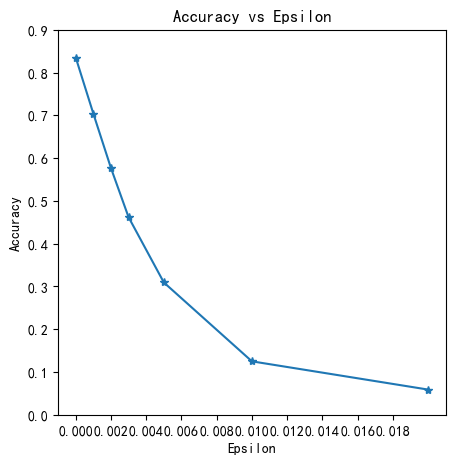

In [9]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.0, step=0.1))
plt.xticks(np.arange(0, .02, step=0.002))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

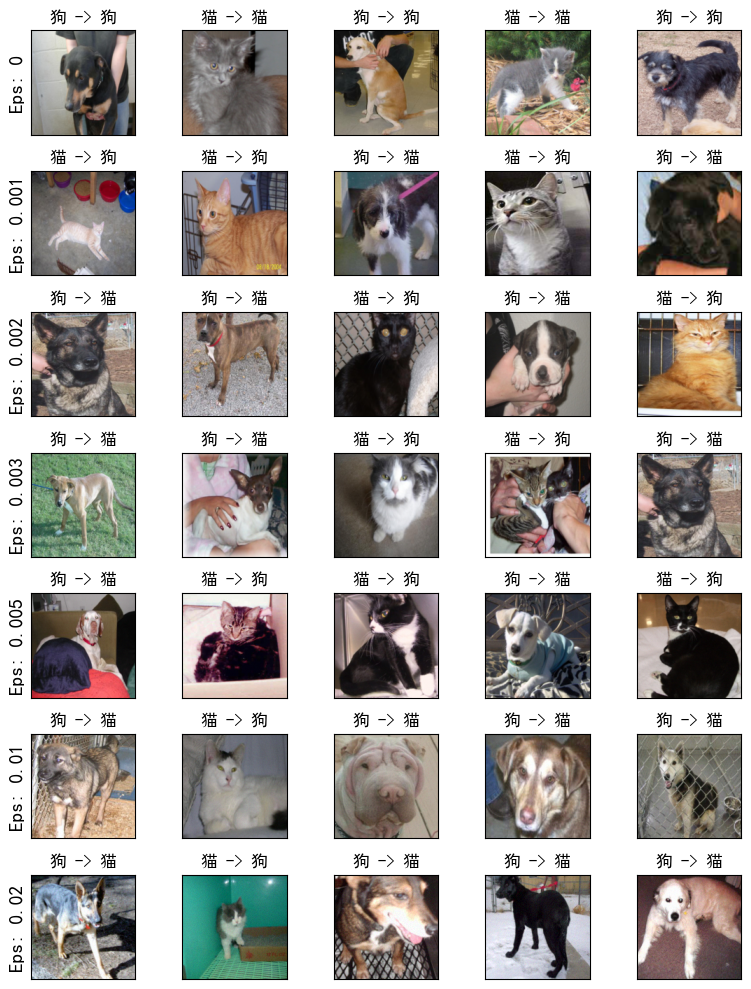

In [10]:
# 绘制每个epsilon的若干对抗样本
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        orig = '猫' if orig == 0 else '狗'
        adv = '猫' if adv == 0 else '狗'
        plt.title("{} -> {}".format(orig, adv))
        # 转置图像数据从 (3, 150, 150) 到 (150, 150, 3)
        ex = ex.transpose((1, 2, 0))
        plt.imshow(ex)
plt.tight_layout()
plt.show()